In [70]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
import qiskit.visualization
import numpy as np
from qiskit.quantum_info import Operator
from sympy import symbols, Eq, solve, cos, sin, I, pi, exp
from qiskit.circuit import Parameter, Gate
from qiskit.quantum_info.operators import Operator
from scipy.optimize import fsolve
from qiskit._accelerate import euler_one_qubit_decomposer,two_qubit_decompose
from qiskit.circuit.library.standard_gates import HGate, CCXGate, multi_control_rotation_gates
import qiskit.quantum_info as qi


Decomposição ZYZ porta Hadamard

In [4]:
#Resolvendo o Sistema 
S = np.array([[1, -1/2, -1/2], [1, -1/2, 1/2], [1, 1/2, -1/2]])
V = np.array([0, np.pi, 0])
gamma = np.pi/2
x = np.linalg.solve(S, V)
alpha = x[0]
beta  = x[1]
delta = x[2]

In [5]:
print(f"alpha: {alpha}")
print(f"beta: {beta}")
print(f"gamma: {gamma}")
print(f"delta: {delta}")

alpha: 1.5707963267948966
beta: 0.0
gamma: 1.5707963267948966
delta: 3.141592653589793


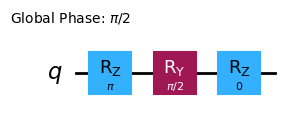

In [6]:
#montando circuito
circuito = QuantumCircuit(1)
gamma = np.pi/2
circuito.global_phase = alpha 
circuito.rz(delta,0)
circuito.ry(gamma,0)
circuito.rz(beta,0)
circuito.draw('mpl')


In [7]:
unitary = Operator(circuito).data
print(unitary)

[[ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]
 [ 0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j]]


Decomposição ZYZ:  Generalização

In [8]:
def decompose_ZYZ(U):
    #checando se e unitaria
    if not np.allclose(U.conj().T @ U, np.eye(2)):
        raise ValueError("The input matrix is not unitary.")

 
    alpha = np.angle(np.linalg.det(U)) / 2
    U = U * np.exp(-1j * alpha)
    if np.isclose(np.abs(U[0, 0]), 1):
        beta = 0.0
        gamma = 0.0
        delta = np.angle(U[1, 1]) - np.angle(U[0, 0])
    elif np.isclose(U[0, 0], 0):
        beta = np.pi
        gamma = np.angle(U[1, 0])
        delta = -np.angle(U[0, 1])
    else:
        beta = 2 * np.arccos(np.abs(U[0, 0]))
        gamma = np.angle(U[1, 0]) - np.angle(U[0, 0])
        delta = np.angle(U[1, 1]) - np.angle(U[1, 0])



    return alpha, beta, gamma, delta

Ex1: Porta Hadamard

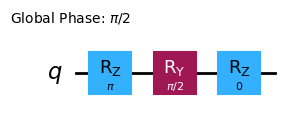

In [9]:
U = np.array([
    [1/np.sqrt(2), 1/np.sqrt(2)],
    [1/np.sqrt(2), -1/np.sqrt(2)]
], dtype=complex)

alpha, beta, gamma, delta = decompose_ZYZ(U)
cq = QuantumCircuit(1)
cq = QuantumCircuit(1)
cq.rz(delta, 0)
cq.ry(beta, 0)
cq.rz(gamma, 0)
cq.global_phase = alpha


cq.draw('mpl')


In [10]:
unitary = Operator(cq).data
print(unitary)

[[ 0.70710678+0.00000000e+00j  0.70710678-8.65956056e-17j]
 [ 0.70710678+0.00000000e+00j -0.70710678+8.65956056e-17j]]


Ex2: Porta X

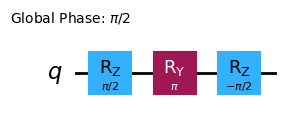

In [11]:
U = np.array([
    [0, 1],
    [1, 0]
], dtype=complex)

alpha, beta, gamma, delta = decompose_ZYZ(U)
cq = QuantumCircuit(1)
cq = QuantumCircuit(1)
cq.rz(delta, 0)
cq.ry(beta, 0)
cq.rz(gamma, 0)
cq.global_phase = alpha


cq.draw('mpl')


In [12]:
unitary = Operator(cq).data
print(unitary)

[[0.+6.12323400e-17j 1.-2.22044605e-16j]
 [1.+2.22044605e-16j 0.+6.12323400e-17j]]


Decomposição ZYZ para portas controladas:  Generalização

In [46]:
def decompose_ZYZ_controlled(U):

    alpha, beta, gamma, delta = decompose_ZYZ(U)

    # Criando as portas A ,B ,C
    
    #C
    circuit_C = QuantumCircuit(1)
    circuit_C.rz((delta-beta)/2,0)
    gate_C = circuit_C.to_gate(label= 'C')
    
    #B
    circuit_B = QuantumCircuit(1)
    circuit_B.ry(-gamma/2,0)
    circuit_B.rz(-(delta+beta)/2,0)
    gate_B = circuit_B.to_gate(label = 'B')
    
    #A
    circuit_A = QuantumCircuit(1)
    circuit_A.rz(beta,0)
    circuit_A.ry(gamma/2,0)
    gate_A = circuit_A.to_gate(label = 'A')

    # Criando o circuito 
    circuit = QuantumCircuit(2)
    
    # Aplicando as portas
    circuit.append(gate_C, [1])
    circuit.cx(0, 1)
    circuit.append(gate_B, [1])
    circuit.cx(0, 1)
    circuit.append(gate_A, [1])

    V = np.array([[1, 0],
                  [0, np.exp(1j * alpha)]])
    circuit.unitary(V, [0], label='V')  # Aplicado ao qubit 0

    return circuit


Ex: Hadamard Controlada

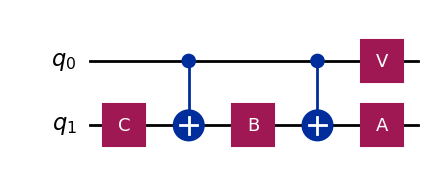

In [47]:
U = np.array([
    [1/np.sqrt(2), 1/np.sqrt(2)],
    [1/np.sqrt(2), -1/np.sqrt(2)]
], dtype=complex)


qc = QuantumCircuit(2)
qc = decompose_ZYZ_controlled(U)
qc.draw('mpl')


Porta com 2 qubits de controle

In [64]:
def control_gate_circuit(V):
    qc = QuantumCircuit(3)

    # Criar a porta V usando a matriz unitária fornecida
    V_gate = Gate(name='V', num_qubits=1, params=[])
    V_gate.definition = QuantumCircuit(1)
    V_gate.definition.unitary(V, [0])

    # Criar a versão controlada da porta V
    V_controlled = V_gate.control(1)

    # Calcular a adjunta da matriz V
    V_adj = np.conj(V.T)

    # Criar a porta adjunta de V
    V_adj_gate = Gate(name='V_adj', num_qubits=1, params=[])
    V_adj_gate.definition = QuantumCircuit(1)
    V_adj_gate.definition.unitary(V_adj, [0])

    # Criar a versão controlada da porta adjunta
    V_controlled_adj = V_adj_gate.control(1)

    # Adicionar as operações conforme descrito
    qc.append(V_controlled, [1, 2])
    qc.cx(0, 1)
    qc.append(V_controlled_adj, [1, 2])
    qc.cx(0, 1)
    qc.append(V_controlled, [0, 2])

    return qc

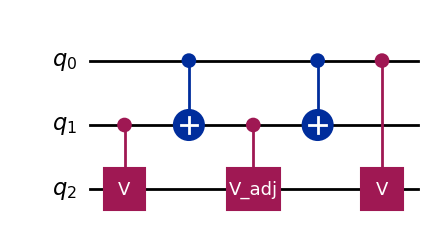

In [65]:
# Definir a porta V (sqrt(Hadamard))
V = np.array([
    [1/np.sqrt(2), 1/np.sqrt(2)],
    [1/np.sqrt(2), -1/np.sqrt(2)]
], dtype=complex)

qc = control_gate_circuit(V)
qc.draw('mpl')

Porta Toffoli

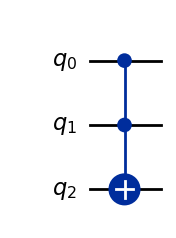

In [100]:
toffoli = QuantumCircuit(3)
toffoli.ccx(0,1,2)
toffoli.draw('mpl')

In [115]:
def Toffoli_circuit():
    
    #porta T 
    T = np.array([[1, 0],
                  [0, np.exp(1j * np.pi/8)]])
    T_operator = Operator(T)
    qc_T = QuantumCircuit(1)
    qc_T.unitary(T_operator, [0])
    T_gate = qc_T.to_gate(label = 'T')

    #porta T_adj
    T_adj = np.array([[1, 0],
                  [0, np.exp(-1j * np.pi/8)]])
    T_adj_operator = Operator(T_adj)
    qc_T_adj = QuantumCircuit(1)
    qc_T_adj.unitary(T_adj_operator, [0])
    T_adj_gate = qc_T_adj.to_gate(label = 'T†')

    #porta S
    S = np.array([[1, 0],
                  [0, 1j]])
    S_operator = Operator(S)
    qc_S = QuantumCircuit(1)
    qc_S.unitary(S_operator, [0])
    S_gate = qc_S.to_gate(label= 'S')

    #montando circuito
    circuit = QuantumCircuit(3)
    circuit.append(HGate(), [2])
    circuit.cx(1,2)
    circuit.append(T_adj_gate, [2])
    circuit.cx(0,2)
    circuit.append(T_gate, [2])
    circuit.cx(1,2)
    circuit.append(T_adj_gate, [2])  
    circuit.cx(0,2)
    circuit.append(T_gate, [2])
    circuit.append(T_adj_gate, [1])
    circuit.append(HGate(), [2])
    circuit.cx(0,1)
    circuit.append(T_adj_gate, [1])
    circuit.cx(0,1)
    circuit.append(T_gate, [0])
    circuit.append(S_gate, [1])


    
    return circuit

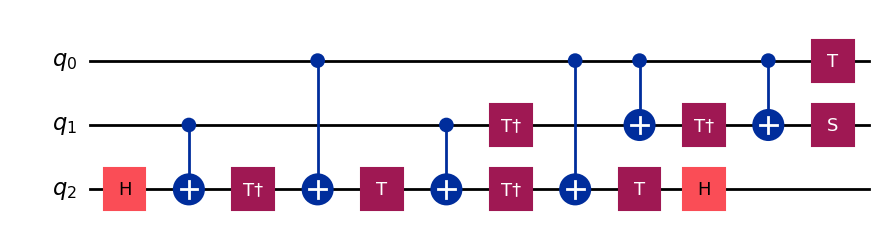

In [116]:
qc = Toffoli_circuit()
qc.draw('mpl')

In [117]:
qc_unitary = Operator(qc).data
toffoli_unitary = Operator(toffoli).data

#Comparando as matrizes unitárias

if np.allclose(qc_unitary, toffoli_unitary, atol=1e-6):
    print("As matrizes são equivalentes.")
else:
    print("As matrizes não são equivalentes.")

As matrizes não são equivalentes.
